**Data Exploration**

In [544]:
# Utility Imports
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization Imports
import seaborn as sns
import matplotlib.pyplot as plt

# Mode-building Imports
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten


# Reading in the data.
df = pd.read_csv('../data-major-cities/train.csv')
now = datetime.now()

def clean(text):
    """"
        The clean function takes in one argument (text) and returns a modified/cleaned list of word values.
    """
    
    # texts is a list of words from the argument 'text'
    texts = text.strip("{}").replace(" ","_").replace("\"","").replace(","," ").lower().split(" ")
    tokens = []
    
    # removing redundant values from the texts list
    for x in texts:
        if x != "translation_missing:_en.hosting_amenity_49" and x != "translation_missing:_en.hosting_amenity_50" and len(x) >=1:
            tokens.append(x)
    return tokens

def get_days(text):
    """
        get_days has one argument (text)
        
        It is used to create a new feature in the data set 'host_since_days'
        
    """
    if type(text) == float:
        return 0
    date = text.split('-')
    days = ((now.year - int(date[0])) * 365) + ((now.month - int(date[1])) * 30) + (int(date[2]))
    return days

def get_token_doc():
    """
        Applied to the same column as clean. This takes in a list of words and converts to a set to remove repeated values.
        
        Doc takes in a word and gives it a doc object number valuation (enumerate)
    """
    tokens = set()
    for lists in df['amenities']:
        for x in lists:
            tokens.add(x)
    token_doc = {}
    for i, x in enumerate(tokens):
        token_doc[x] = i
    return token_doc

def tokenize(word_list,token_doc):
    """
        Encoding word_list (amenities) with new number values for tokenization.
    """
    encoded_list = []
    for word in word_list:
        encoded_list.append(token_doc[word])
    return encoded_list

# Feature engineering

# The daily price of the AirBnb listing.
df['price'] = df['log_price'].apply(lambda x : round(np.exp(x)))

# Cleaning the amenities column.
df['amenities'] = df['amenities'].apply(clean)
df['amenities'] = df['amenities'].apply(lambda x: len(x))
# Tokenizing the amenities column.
#token_doc = get_token_doc()
#df['amenities'] = df['amenities'].apply(tokenize,token_doc=token_doc)

# Applying the get_days function to create a new feature = total number of hosted days.
df['host_since_days'] = df['host_since'].apply(get_days)

# Dropping redundant columns.
df.drop(columns=['host_since','log_price','id','latitude','longitude','name','description','thumbnail_url','review_scores_rating','number_of_reviews','host_has_profile_pic','host_response_rate','last_review','first_review'],inplace=True)

# A new column: Is the room isntantly bookable.
df['instant_bookable'].replace(('f','t'),("False",'True'),inplace=True)

# A new column: is the hosts' identity verified.
df['host_identity_verified'].replace(('f','t'),("False",'True'),inplace=True)

# Dropping null values
df = df.dropna(axis=0)

In [545]:
# Splitting the data
Y = df['price']
X = df.drop(columns=['price'])

**Visualizations**

array([[<AxesSubplot:title={'center':'amenities'}>,
        <AxesSubplot:title={'center':'accommodates'}>],
       [<AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>],
       [<AxesSubplot:title={'center':'beds'}>,
        <AxesSubplot:title={'center':'host_since_days'}>]], dtype=object)

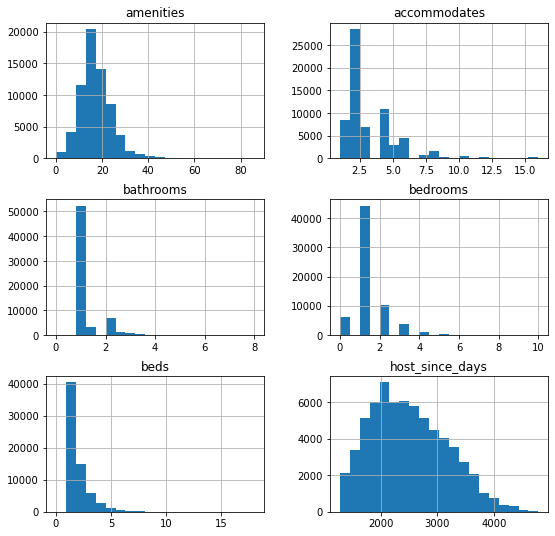

In [546]:
# Plotting the targeted features.
X.hist(figsize=(9,9),bins = 20)

In [547]:
df['target/price'] = df['price']
df.drop(columns=['price'],inplace=True)

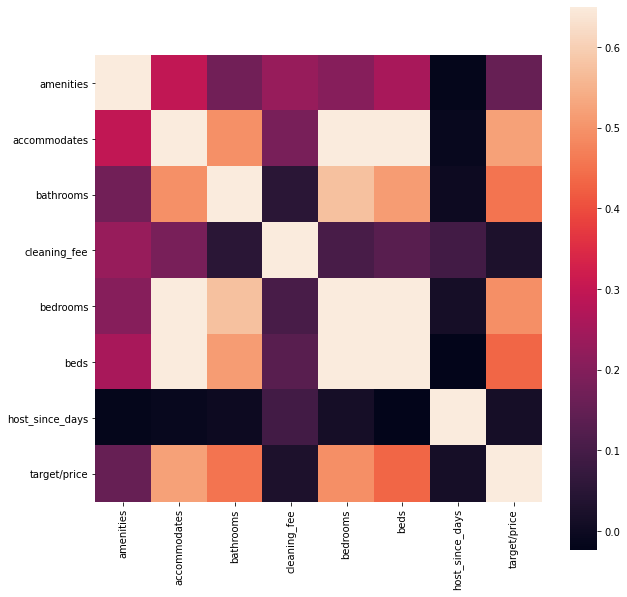

In [548]:
x = df.corr()
figure = plt.figure(figsize=(10,10))
sns.heatmap(x,vmax=0.65,square=True)
plt.show()


In [549]:
from sklearn.preprocessing import OrdinalEncoder
X_strings = X.select_dtypes(include='object')
X_non_strings = X.select_dtypes(include=['int64','float'])
oe =OrdinalEncoder()
oe.fit(X_strings)
X_train = oe.transform(X_strings)

In [550]:
X_train_whole = np.concatenate((X_train,X_non_strings),axis=1)

model_columns = X_strings.columns.append(X_non_strings.columns)

In [551]:
xd = X_strings.loc[0].values.reshape(1,-1)
df_rows = []
def get_input_vector(input_list_objects,input_list_numbers):
    ordinal_encoded_vector = oe.transform(input_list_objects).tolist()[0]
    encoded_vector = ordinal_encoded_vector + input_list_numbers
    for i in np.arange(len(X_strings.columns)):
        df_rows.append((model_columns[i],input_list_objects[0][i],ordinal_encoded_vector[i]))
    for i in np.arange(9,len(model_columns)):
        df_rows.append((model_columns[i],input_list_numbers[i-9],input_list_numbers[i-9]))
    confirm_df = pd.DataFrame(df_rows,columns=['Variable','Value','Encoded'])
    return encoded_vector,confirm_df
print(X_train_whole[0])
x,confirm_df = get_input_vector(xd, X_non_strings.loc[0].values.tolist())

[0.000e+00 0.000e+00 4.000e+00 2.000e+00 4.000e+00 1.000e+00 0.000e+00
 7.600e+01 1.910e+02 8.000e+00 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 3.341e+03]


In [552]:
input_dims = len(X_train_whole[0])


model = Sequential()

model.add(Dense(input_dims,input_dim=input_dims, activation="relu", kernel_initializer='normal'))
model.add(Dense(1,activation="linear",kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.fit(X_train_whole,Y,epochs=10, batch_size=32, validation_split = 0.2)

Epoch 1/10
1655/1655 [==============================] - 2s 1ms/step - loss: 28325.6934 - mean_absolute_error: 96.2039 - val_loss: 27565.3613 - val_mean_absolute_error: 91.0279
Epoch 2/10
1655/1655 [==============================] - 2s 1ms/step - loss: 24351.3281 - mean_absolute_error: 87.3756 - val_loss: 23234.5020 - val_mean_absolute_error: 78.8738
Epoch 3/10
1655/1655 [==============================] - 2s 1ms/step - loss: 20838.7500 - mean_absolute_error: 79.1053 - val_loss: 20771.2695 - val_mean_absolute_error: 75.2706
Epoch 4/10
1655/1655 [==============================] - 2s 1ms/step - loss: 19193.0762 - mean_absolute_error: 74.2279 - val_loss: 19955.4570 - val_mean_absolute_error: 80.7613
Epoch 5/10
1655/1655 [==============================] - 2s 1ms/step - loss: 18430.3379 - mean_absolute_error: 71.6671 - val_loss: 19237.6172 - val_mean_absolute_error: 75.9259
Epoch 6/10
1655/1655 [==============================] - 2s 1ms/step - loss: 18107.1016 - mean_absolute_error: 70.4926 - 

In [553]:
model.predict(np.array(x).reshape(1,-1))[0][0]

157.50714

In [556]:
df.loc[0]['target/price']

150

In [557]:
confirm_df

,Variable,Value,Encoded
0,property_type,Apartment,0.0
1,room_type,Entire home/apt,0.0
2,bed_type,Real Bed,4.0
3,cancellation_policy,strict,2.0
4,city,NYC,4.0
5,host_identity_verified,True,1.0
6,instant_bookable,False,0.0
7,neighbourhood,Brooklyn Heights,76.0
8,zipcode,11201,191.0
9,amenities,8.0,8.0
